In [23]:
import os, random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import re
from collections import defaultdict
import pickle
import random
from itertools import combinations
import numpy as np
from sklearn.metrics import roc_curve, auc, accuracy_score

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# BASE = "/kaggle/input/logo-dataset-2341-classes-and-167140-images/datasetcopy"
# LIST_DIR = os.path.join(BASE, "List")
# TRAIN_LIST = os.path.join(LIST_DIR, "train_images_root.txt")
# TEST_LIST  = os.path.join(LIST_DIR, "test_images_root.txt")

# TRAIN_ROOT = os.path.join(BASE, "trainandtest", "train")
# TEST_ROOT  = os.path.join(BASE, "trainandtest", "test")

# def build_from_txt(list_file, base_dir):
#     by_class = defaultdict(list)
#     with open(list_file, "r", encoding="utf-8") as f:
#         for line in f:
#             line = line.strip()
#             #rel_path = line.strip().replace("\\", "/").replace(" ", "").replace("'", "")
#             #rel_path = re.sub(r'[^A-Za-z0-9/.]', '', line)
#             if not line: 
#                 continue
#             parts = line.split("/")
#             if len(parts) < 3:
#                 continue
#             company = re.sub(r'[^A-Za-z0-9]', '', parts[1])
#             rel_path = "/".join([parts[0], company, parts[2]])
#             full_path = os.path.join(base_dir, rel_path)
#             if not os.path.exists(full_path):
#                 continue
#             by_class[company].append(full_path)
#     return by_class

# train_by_class = build_from_txt(TRAIN_LIST, TRAIN_ROOT)
# test_by_class  = build_from_txt(TEST_LIST, TEST_ROOT)

# classes = list(train_by_class.keys())

In [40]:
TRAIN_ROOT = "/kaggle/input/logo-dataset-2341-classes-and-167140-images/datasetcopy/trainandtest/train"
TEST_ROOT  = "/kaggle/input/logo-dataset-2341-classes-and-167140-images/datasetcopy/trainandtest/test"

def build_class_map(root):
    by_class = {}
    for root_dir, dirs, files in os.walk(root):
        if len(files) > 0:
            subclass = os.path.basename(root_dir)
            imgs = [os.path.join(root_dir, f) for f in files if f.lower().endswith(('.jpg','.png','.jpeg'))]
            if len(imgs) >= 2:
                by_class[subclass] = imgs
    print(f"Loaded {len(by_class)} classes from {root}")
    return by_class

train_by_class = build_class_map(TRAIN_ROOT)
test_by_class  = build_class_map(TEST_ROOT)
classes = list(train_by_class.keys())

Loaded 2337 classes from /kaggle/input/logo-dataset-2341-classes-and-167140-images/datasetcopy/trainandtest/train
Loaded 2337 classes from /kaggle/input/logo-dataset-2341-classes-and-167140-images/datasetcopy/trainandtest/test


In [42]:
with open("dataset_maps.pkl", "wb") as f:
    pickle.dump({
        "train_by_class": train_by_class,
        "test_by_class": test_by_class,
        "classes": classes
    }, f)

print("✅ Сохранено в dataset_maps.pkl")

✅ Сохранено в dataset_maps.pkl


In [6]:
with open("/kaggle/input/classes-of-logo-dataset/dataset_maps.pkl", "rb") as f:
    data = pickle.load(f)

train_by_class = data["train_by_class"]
test_by_class  = data["test_by_class"]
classes        = data["classes"]

In [7]:
class TripletLogoDataset(Dataset):
    def __init__(self, by_class_map, transform=None):
        self.by_class = by_class_map
        self.classes = list(by_class_map.keys())
        self.transform = transform

    def __len__(self):
        return sum(len(v) for v in self.by_class.values())

    def _load(self, path):
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

    def __getitem__(self, idx):
        anchor_class = random.choice(self.classes)
        positives = self.by_class[anchor_class]
        a, p = random.sample(positives, 2)

        neg_class = random.choice(self.classes)
        while neg_class == anchor_class:
            neg_class = random.choice(self.classes)
        n = random.choice(self.by_class[neg_class])

        return self._load(a), self._load(p), self._load(n), anchor_class

In [8]:
transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

batch_size = 64
num_workers = 4

train_ds = TripletLogoDataset(train_by_class, transform)
test_ds  = TripletLogoDataset(test_by_class, transform)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

In [9]:
class LogoSiamese(nn.Module):
    def __init__(self, backbone, feature_dim, embedding_dim):
        super().__init__()
        self.backbone = backbone
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        x = nn.functional.normalize(x, p=2, dim=1)
        return x

In [10]:
embedding_dim = 256
feature_dim = 2048
lr = 1e-3
num_epochs = 2

In [11]:
class DualPoolResNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(base.children())[:-3])
        self.out_channels = 1024  

    def forward(self, x):
        x = self.features(x)
        avg = F.adaptive_avg_pool2d(x, 1)
        mx = F.adaptive_max_pool2d(x, 1)
        x = torch.cat([avg, mx], dim=1)
        return x.view(x.size(0), -1)  

In [12]:
backbone = DualPoolResNetBackbone()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 230MB/s]


In [13]:
for param in backbone.parameters():
    param.requires_grad = False

model = LogoSiamese(backbone, feature_dim, embedding_dim).to(device)

criterion = nn.TripletMarginLoss(margin=0.3)
optimizer = optim.Adam(model.head.parameters(), lr=lr)

In [14]:
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    batch_losses = []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for i, (a, p, n, _) in enumerate(pbar):
        a, p, n = a.to(device), p.to(device), n.to(device)

        fa, fp, fn = model(a), model(p), model(n)
        loss = criterion(fa, fp, fn)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 10 == 0:
            avg_batch_loss = running_loss / 10
            train_losses.append(avg_batch_loss)
            batch_losses.append(avg_batch_loss)
            pbar.set_postfix({"train_loss": f"{avg_batch_loss:.4f}"})
            running_loss = 0.0

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for a, p, n, _ in test_loader:
            a, p, n = a.to(device), p.to(device), n.to(device)
            fa, fp, fn = model(a), model(p), model(n)
            loss = criterion(fa, fp, fn)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    pbar.close()
    print(f"Epoch [{epoch+1}/{num_epochs}]  Test Loss: {avg_test_loss:.4f}")

Epoch [1/2]  Test Loss: 0.1430


Epoch [2/2]  Test Loss: 0.1403


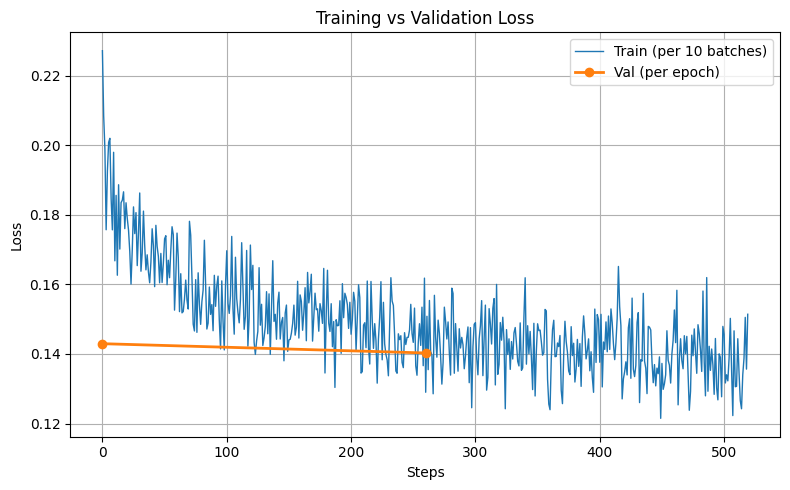

In [15]:
plt.figure(figsize=(8,5))

plt.plot(train_losses, label="Train (per 10 batches)", linewidth=1)

plt.plot(
    [i * (len(train_loader)//10) for i in range(len(test_losses))],
    test_losses, label="Val (per epoch)", linewidth=2, marker="o"
)

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
def build_val_pairs(by_class_map, num_pos=1000, num_neg=1000):
    classes = list(by_class_map.keys())
    pairs = []

    for cls in classes:
        imgs = by_class_map[cls]
        if len(imgs) < 2:
            continue
        pos_combos = list(combinations(imgs, 2))
        random.shuffle(pos_combos)
        for a, b in pos_combos[:num_pos // len(classes) + 1]:
            pairs.append((a, b, 1))

    for _ in range(num_neg):
        c1, c2 = random.sample(classes, 2)
        a = random.choice(by_class_map[c1])
        b = random.choice(by_class_map[c2])
        pairs.append((a, b, 0))

    random.shuffle(pairs)
    return pairs

In [19]:
val_pairs = build_val_pairs(test_by_class, num_pos=2000, num_neg=2000)

In [21]:
model.eval()
distances, labels = [], []

transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

def load_image(path):
    img = Image.open(path).convert("RGB")
    return transform(img)

with torch.no_grad():
    for path1, path2, label in val_pairs:
        img1 = load_image(path1).to(device)
        img2 = load_image(path2).to(device)

        emb1 = model(img1.unsqueeze(0))
        emb2 = model(img2.unsqueeze(0))

        dist = F.pairwise_distance(emb1, emb2).item()
        distances.append(dist)
        labels.append(label)

In [24]:
fpr, tpr, thresholds = roc_curve(labels, [-d for d in distances])  
roc_auc = auc(fpr, tpr)

best_thresh = thresholds[np.argmax(tpr - fpr)]
print(f"AUC = {roc_auc:.4f}, Best threshold = {best_thresh:.4f}")

AUC = 0.8068, Best threshold = -0.8011


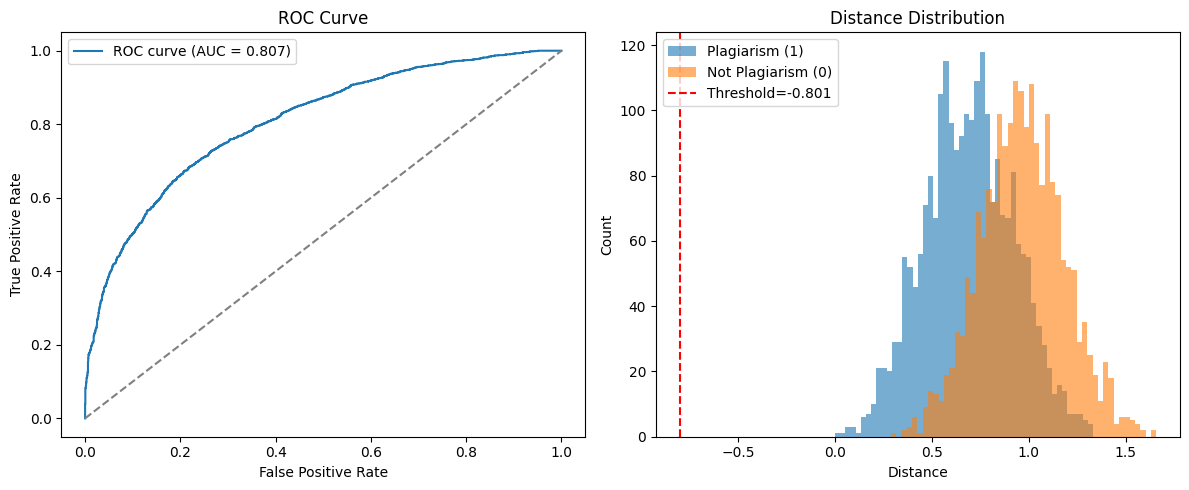

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1,2,2)
pos_d = [d for d, l in zip(distances, labels) if l == 1]
neg_d = [d for d, l in zip(distances, labels) if l == 0]
plt.hist(pos_d, bins=50, alpha=0.6, label="Plagiarism (1)")
plt.hist(neg_d, bins=50, alpha=0.6, label="Not Plagiarism (0)")
plt.axvline(best_thresh, color='red', linestyle='--', label=f"Threshold={best_thresh:.3f}")
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Distance Distribution")
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
save_path = "logo_siamese_checkpoint.pth"

torch.save({
    "epoch": epoch,         
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": avg_test_loss,         
    "embedding_dim": embedding_dim,
    "feature_dim": feature_dim
}, save_path)